In [1]:
#import libraries
import torch
import torch.nn as nn  
import scipy
import numpy as np
import matplotlib.pyplot as plt
from gstools import SRF, Gaussian
from gstools.random import MasterRNG
from scipy import integrate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generating Data (m = # of random fields generated by the GRF, n = collocation points)
m = 100
n = 110

x = np.linspace(0, 1, m)

seed = MasterRNG(20250211)
def one_function(x):
    model = Gaussian(dim=1, var=3, len_scale=0.2)
    srf = SRF(model, seed=seed())
    f = srf.structured([x])
    return f

U = np.zeros((m, n))
for i in range(n):
    U[:, i] = one_function(x)

def integrate_one_function(f):
    result = np.zeros_like(f)
    result[0] = 0
    for i in range(1, len(f)):
        result[i] = integrate.simpson(f[:i+1], x=x[:i+1])  # Numerical integration using Simpson's rule
    return result

S = np.zeros((m, n))
for i in range(n):
    S[:, i] = integrate_one_function(U[:, i])

# example data ( integration result for specific x value to function)
i = 10
j = 5
u = U[:, i]
x_ = x[j]
s = S[j, i]

u = torch.tensor(u, dtype=torch.float32).unsqueeze(1)
x_ = torch.tensor([x_], dtype=torch.float32).unsqueeze(1)
s = torch.tensor([s], dtype=torch.float32).unsqueeze(1)

U_train = torch.tensor(U, dtype=torch.float32)
S_train = torch.tensor(S, dtype=torch.float32)
x_train = torch.tensor(x, dtype=torch.float32).unsqueeze(1)

def integrate_dataset(m=m, n=n, x=x, U=U, S=S):
    us = np.zeros((m * n, m))
    xs = np.zeros((m * n, 1))
    ss = np.zeros((m * n, 1))
    for i in range(n):
        for j in range(m):
            us[i * m + j, :] = U[:, i]
            xs[i * m + j, :] = x[j]
            ss[i * m + j, :] = S[j, i]
    return us, xs, ss

us, xs, ss = integrate_dataset()

def batch_dataset(batch_size, m=m, n=n, x=x, U=U, S=S, ratio=0.8):
    us, xs, ss = integrate_dataset(m, n, x, U, S)
    train_size = int(len(us) * ratio)
    us_train = us[:train_size]
    xs_train = xs[:train_size]
    ss_train = ss[:train_size]

    us_test = us[train_size:]
    xs_test = xs[train_size:]
    ss_test = ss[train_size:]

    us_train = torch.tensor(us_train, dtype=torch.float32)
    xs_train = torch.tensor(xs_train, dtype=torch.float32)
    ss_train = torch.tensor(ss_train, dtype=torch.float32)

    train_dataset = torch.utils.data.TensorDataset(us_train, xs_train, ss_train)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    us_test = torch.tensor(us_test, dtype=torch.float32)
    xs_test = torch.tensor(xs_test, dtype=torch.float32)
    ss_test = torch.tensor(ss_test, dtype=torch.float32)

    test_dataset = torch.utils.data.TensorDataset(us_test, xs_test, ss_test)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_dataloader, test_dataloader

# datasets
train_data, test_data = batch_dataset(40, ratio=0.9)

class DeepONet(nn.Module):
    def __init__(self, neurons=40, in1=1, in2=1, output_neurons=20):
        super(DeepONet, self).__init__()
        self.neurons = neurons
        self.in1 = in1
        self.in2 = in2
        self.output_neurons = output_neurons
        self.b = torch.nn.parameter.Parameter(torch.tensor(0.0))
        self.b1 = self.branch()
        self.b2 = self.trunk()

    def branch(self):
        b1 = nn.Sequential(
            nn.Linear(self.in1, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.output_neurons)
        )
        return b1
    
    def trunk(self):
        b2 = nn.Sequential(
            nn.Linear(self.in2, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.output_neurons)
        )
        return b2
    
    def forward(self, x1, x2):
        x1 = self.b1(x1)
        x2 = self.b2(x2)
        x = torch.einsum("bi, bi -> b", x1, x2)
        x = torch.unsqueeze(x, 1)
        x += self.b
        return x

In [2]:
print("Using device:", device)

class StackedDeepONet(nn.Module):
    output_neurons = 20
    def __init__(self, num_stacks=output_neurons, neurons=40, in1=1, in2=1, output_neurons=output_neurons):

        super(StackedDeepONet, self).__init__()
        self.num_stacks = num_stacks
        self.deeponets = nn.ModuleList([
            DeepONet(neurons=neurons, in1=in1, in2=in2, output_neurons=output_neurons)
            for _ in range(num_stacks)
        ])

        self.combination_layer = nn.Linear(num_stacks, 1)
    
    def forward(self, x1, x2):
        outputs = [net(x1, x2) for net in self.deeponets]
        stacked_outputs = torch.cat(outputs, dim=1)
        out = self.combination_layer(stacked_outputs)
        return out


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate Stacked DeepONet model
stacked_model = StackedDeepONet(num_stacks=20, neurons=40, in1=m, in2=1, output_neurons=20).to(device)

# loss and optimizer
def loss(y_pred, y):
    return torch.mean((y_pred - y)**2)

optimizer = torch.optim.Adam(stacked_model.parameters(), lr=0.001)

train_losses = []
epochs = 60

for epoch in range(epochs):
    stacked_model.train()
    l_total = 0
    for u_batch, x_batch, s_batch in train_data:
        u_batch = u_batch.to(device)
        x_batch = x_batch.to(device)
        s_batch = s_batch.to(device)
        
        optimizer.zero_grad()
        y_pred = stacked_model(u_batch, x_batch)
        l = loss(y_pred, s_batch)
        l.backward()
        optimizer.step()
        l_total += l.item()
        
    l_total = l_total / len(train_data)
    train_losses.append(l_total)
    print(f"Epoch {epoch}, Loss: {l_total:.6f}")
    if l_total < 1e-4:
        break


Using device: cuda
Epoch 0, Loss: 0.045090
Epoch 1, Loss: 0.005479
Epoch 2, Loss: 0.001343
Epoch 3, Loss: 0.000747
Epoch 4, Loss: 0.000916
Epoch 5, Loss: 0.000749
Epoch 6, Loss: 0.000534
Epoch 7, Loss: 0.000676
Epoch 8, Loss: 0.000896
Epoch 9, Loss: 0.001230
Epoch 10, Loss: 0.000754
Epoch 11, Loss: 0.000697
Epoch 12, Loss: 0.000605
Epoch 13, Loss: 0.000549
Epoch 14, Loss: 0.000755
Epoch 15, Loss: 0.000750
Epoch 16, Loss: 0.001658
Epoch 17, Loss: 0.000649
Epoch 18, Loss: 0.000356
Epoch 19, Loss: 0.000594
Epoch 20, Loss: 0.000385
Epoch 21, Loss: 0.000664
Epoch 22, Loss: 0.000760
Epoch 23, Loss: 0.000518
Epoch 24, Loss: 0.000298
Epoch 25, Loss: 0.000523
Epoch 26, Loss: 0.000285
Epoch 27, Loss: 0.000811
Epoch 28, Loss: 0.000741
Epoch 29, Loss: 0.000379
Epoch 30, Loss: 0.000132
Epoch 31, Loss: 0.000144
Epoch 32, Loss: 0.000421
Epoch 33, Loss: 0.000598
Epoch 34, Loss: 0.000513
Epoch 35, Loss: 0.000104
Epoch 36, Loss: 0.000195
Epoch 37, Loss: 0.000167
Epoch 38, Loss: 0.000151
Epoch 39, Loss: 

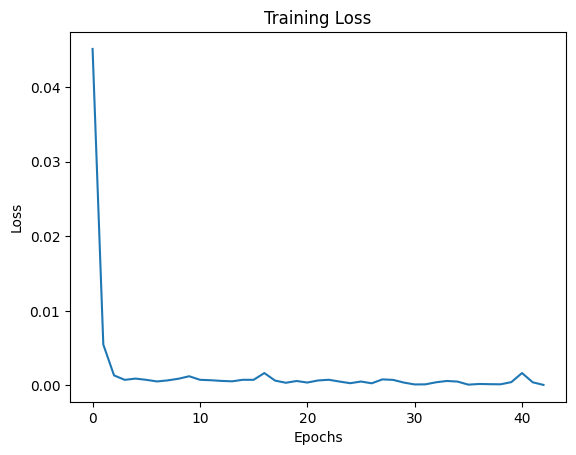

In [3]:
# Plot training loss
plt.plot(train_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

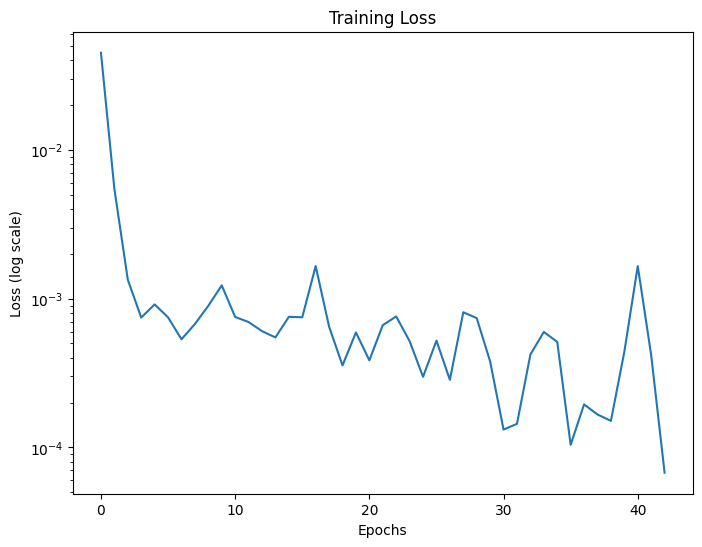

In [4]:
plt.figure(figsize=(8,6))
plt.plot(train_losses)
plt.yscale('log')  # Set y-axis to log scale
plt.xlabel("Epochs")
plt.ylabel("Loss (log scale)")
plt.title("Training Loss")
plt.show()


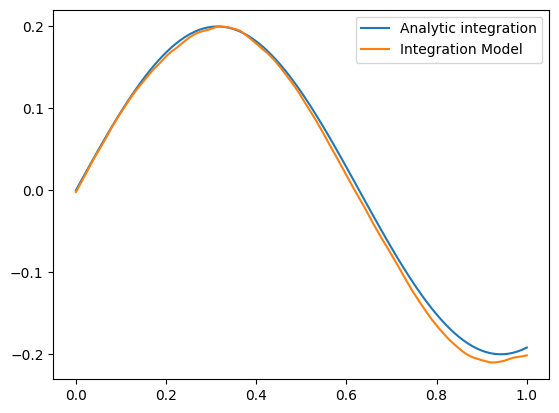

In [5]:
my_func = lambda x: np.cos(5*x)
inter = lambda x: 1/5*np.sin(5*x)
u_t = my_func(x)
s_t = inter(x)

stacked_model = stacked_model.to(device)
stacked_model.eval()
u_t_ = torch.tensor(u_t, dtype= torch.float32).unsqueeze(0).to(device)
x_ = torch.tensor(x, dtype = torch.float32).unsqueeze(1).to(device)
p = stacked_model(u_t_, x_)
p = p.detach().cpu().numpy()

plt.plot(x, s_t, label = "Analytic integration")
plt.plot(x, p, label = "Integration Model")
plt.legend();

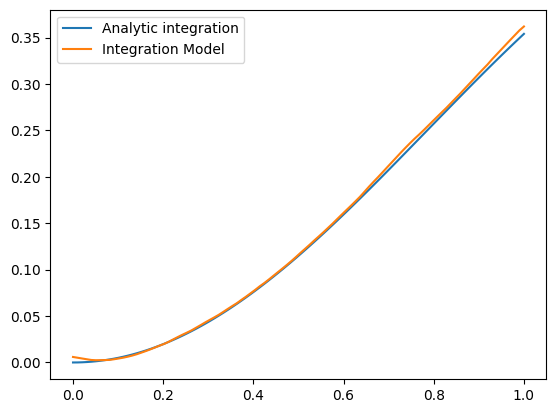

In [6]:
my_func = lambda x: np.cos(x)*np.sin(x)
inter = lambda x: 1/2*(np.sin(x))**2
u_t = my_func(x)
s_t = inter(x)

stacked_model = stacked_model.to(device)
stacked_model.eval()
u_t_ = torch.tensor(u_t, dtype=torch.float32).unsqueeze(0).to(device)
x_ = torch.tensor(x, dtype=torch.float32).unsqueeze(1).to(device)
p = stacked_model(u_t_, x_)
p = p.detach().cpu().numpy()

plt.plot(x, s_t, label = "Analytic integration")
plt.plot(x, p, label = "Integration Model")
plt.legend();